# Determinare la presenza o meno di persone all'interno di un ufficio

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Alessandro Lombardi

Citazioni

- Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. L. M. Candanedo, V. Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

## Parte 1 - Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che utilizzando i dati registrati frequentemente da alcuni sensori posti all'interno di un ufficio possa determinare la presenza o meno di persone al suo interno.

Vengono importate le librerie necessarie per importare i file, organizzare le strutture dati e fare i grafici.

In [1]:
%matplotlib inline
import os.path
import numpy as np
import pandas as pd
from pandas.compat import StringIO
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Caricamento dei dati e preprocessing

In [2]:
file_zip_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
file_zip_name = "occupancy_data.zip"
file_training_set_name = "datatraining.txt"
file_validation_set_name = "datatest.txt"
file_test_set_name = "datatest2.txt"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [3]:
with open(file_training_set_name) as dataFile:
    data_raw = pd.read_csv(dataFile, sep=",")

data_raw.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


Di seguito riporto le dimensioni in memoria, la grandezza e il tipo delle feature che compongono i dati raccolti nel dataset (training set) 

In [4]:
data_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
date             8143 non-null object
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.0 MB


Rinomino le feature `date` con `Date` e `HumidityRatio` con `Humidity_Ratio`

In [5]:
data = data_raw.rename(columns={"date" : "Date",
                                "HumidityRatio": "Humidity_Ratio"})

### Significato delle feature

Riportiamo le informazioni sul dataset tratte dalla [fonte](http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)

Dati di tipo categorico 
- **`Date`** timestamp della misurazione

- **`Temperature`** misura della temperatura misurata in gradi centigradi (C°)

- **`Humidity`** misura dell'umidità relativa in percentuale
i
- **`Light`** misura della luminosità in Lux

- **`CO2`** misura di CO2 nell'aria in parti per milione (ppm)

- **`Humidity_Ratio`** misura derivata dalla umidità e dalla temperatura in Kg di vapore acqueo in Kg di aria 

- **`Occupancy`** indica la presenza di persone nell'ufficio 
  - 1 = presenti 0 = assenti 

In [6]:
data.describe()

,Temperature,Humidity,Light,CO2,Humidity_Ratio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


0    6414
1    1729
Name: Occupancy, dtype: int64


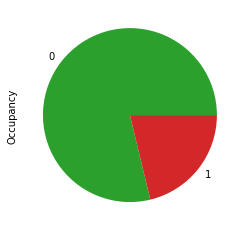

In [7]:
free_color = "#2ca02c"
occupied_color = "#d32829"

class_colors = [free_color, occupied_color]
class_colors_map = {0:free_color, 1:occupied_color}

print(data["Occupancy"].value_counts())
_ = data["Occupancy"].value_counts().plot.pie(colors=class_colors)

In [8]:
def cast_date_time_and_show(dataset):
    dataset["Date"] = pd.to_datetime(dataset["Date"], format="%Y-%m-%d %H:%M:%S")

    print(dataset["Date"].describe())
    #plt.plot(dataset["Date"])
    return dataset


data = cast_date_time_and_show(data)

count                    8143
unique                   8143
top       2015-02-07 17:43:00
freq                        1
first     2015-02-04 17:51:00
last      2015-02-10 09:33:00
Name: Date, dtype: object


Text(0, 0.5, '%')

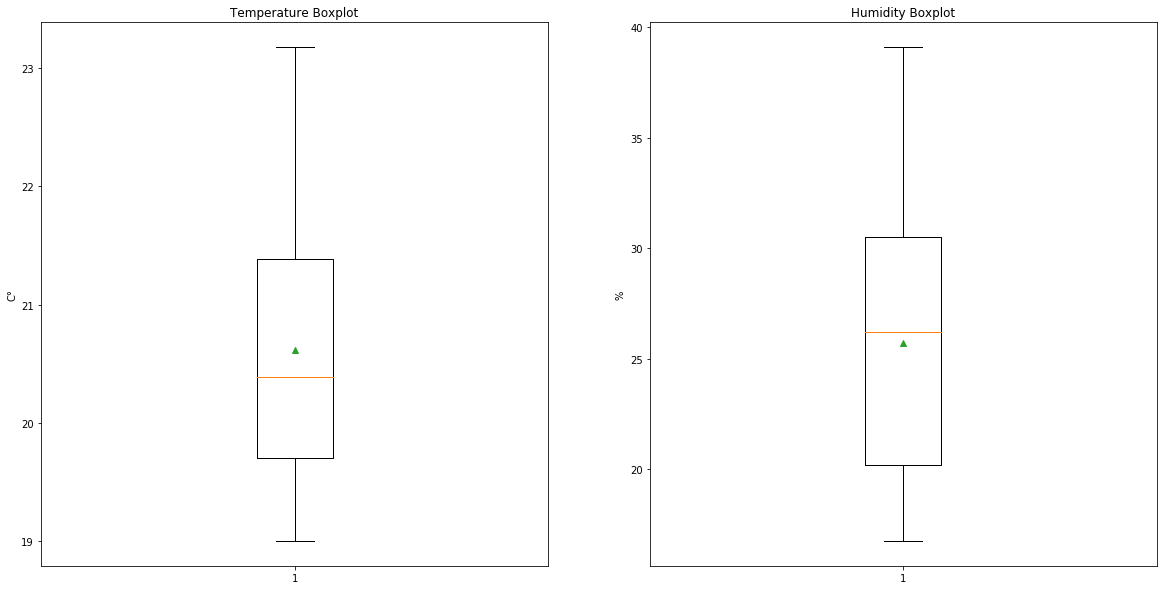

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 10))


axes[0].boxplot(data["Temperature"], showmeans=True)
axes[1].boxplot(data["Humidity"], showmeans=True)
   
axes[0].set_title("Temperature Boxplot")
axes[1].set_title("Humidity Boxplot")
axes[0].set_ylabel("C°")
axes[1].set_ylabel("%")

In [10]:
def plot_box_and_hist(column_name, dataset, symbol=""):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 10))


    axes[0].boxplot(dataset["{}".format(column_name)], showmeans=True)
    axes[1].hist(dataset["{}".format(column_name)], bins=5)
    #data.groupby([pd.cut(data["Light"], bins=5)]).size().plot.bar(figsize=(15,3))
   
    axes[0].set_title("{} Boxplot".format(column_name))
    axes[1].set_title("{} Bar".format(column_name))
    axes[0].set_ylabel(symbol)
    axes[1].set_ylabel(symbol)

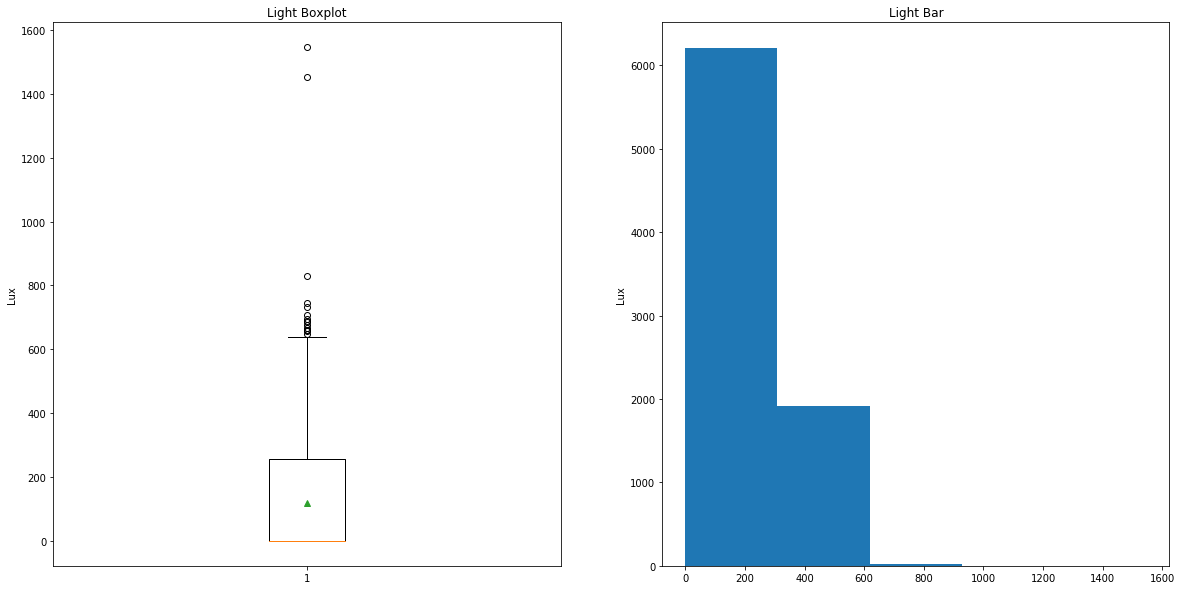

In [11]:
#data.groupby([pd.cut(data["Light"], bins=5)]).size().plot.bar(figsize=(15,3))
plot_box_and_hist("Light", data, "Lux")

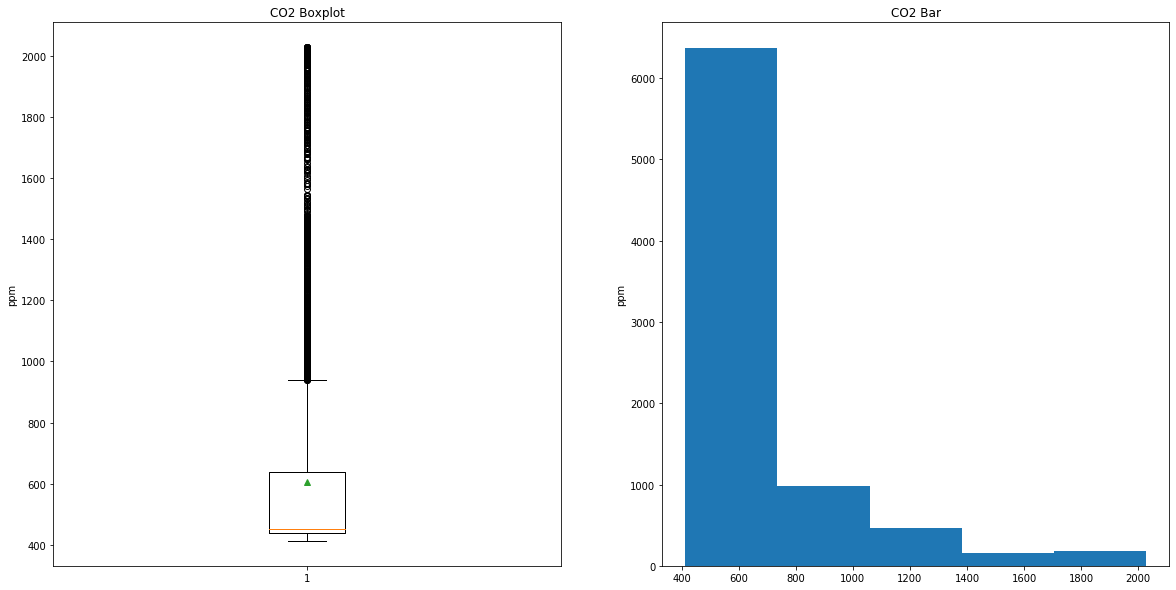

In [12]:
#data.groupby([pd.cut(data["Light"], bins=5)]).size().plot.bar(figsize=(15,3))
plot_box_and_hist("CO2", data, "ppm")

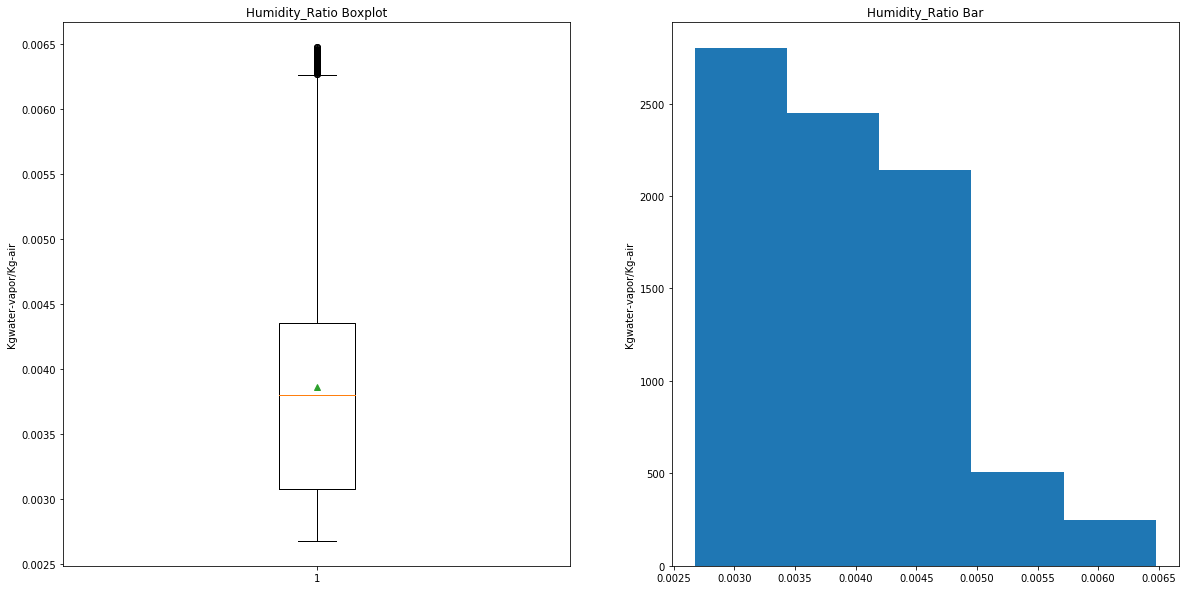

In [13]:
#data.groupby([pd.cut(data["Light"], bins=5)]).size().plot.bar(figsize=(15,3))
plot_box_and_hist("Humidity_Ratio", data, "Kgwater-vapor/Kg-air")

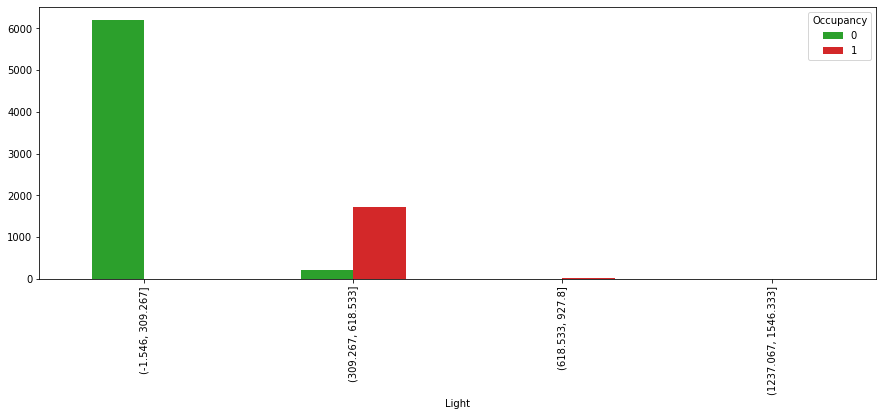

In [14]:
_ = data.groupby([pd.cut(data["Light"], bins=5), "Occupancy"]).size().unstack("Occupancy").plot.bar(stacked=False, color=class_colors, figsize=(15,5))

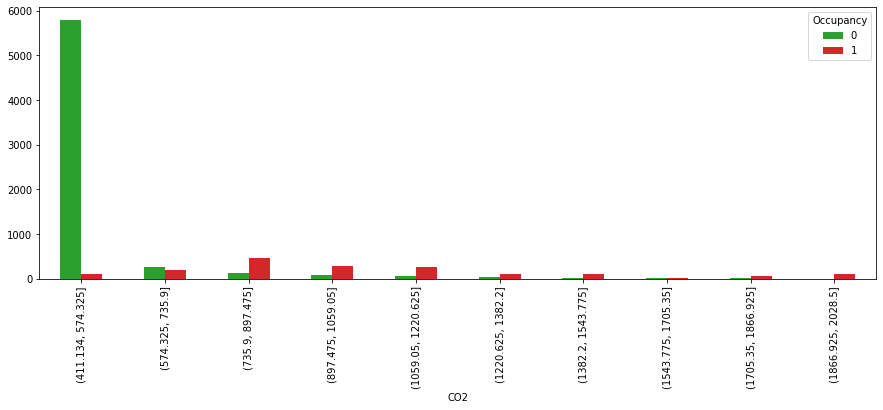

In [15]:
_ = data.groupby([pd.cut(data["CO2"], bins=10), "Occupancy"]).size().unstack("Occupancy").plot.bar(stacked=False, color=class_colors, figsize=(15,5))

#### Humidity_Ratio
Si vuole dimostrare che cresce al crescere di umidità e temperatura cresce anche il valore contenuto in `Humidity_Ratio` che rappresenta la massa di acqua sulla massa d'aria.
Di seguito vengono riportati i valori classificati per colore sulla feature `Occupancy` della temperatura, che ricorda la tabella psicometrica, e dell'umidità.

Text(0, 0.5, 'kgwater-vapor/kg-air')

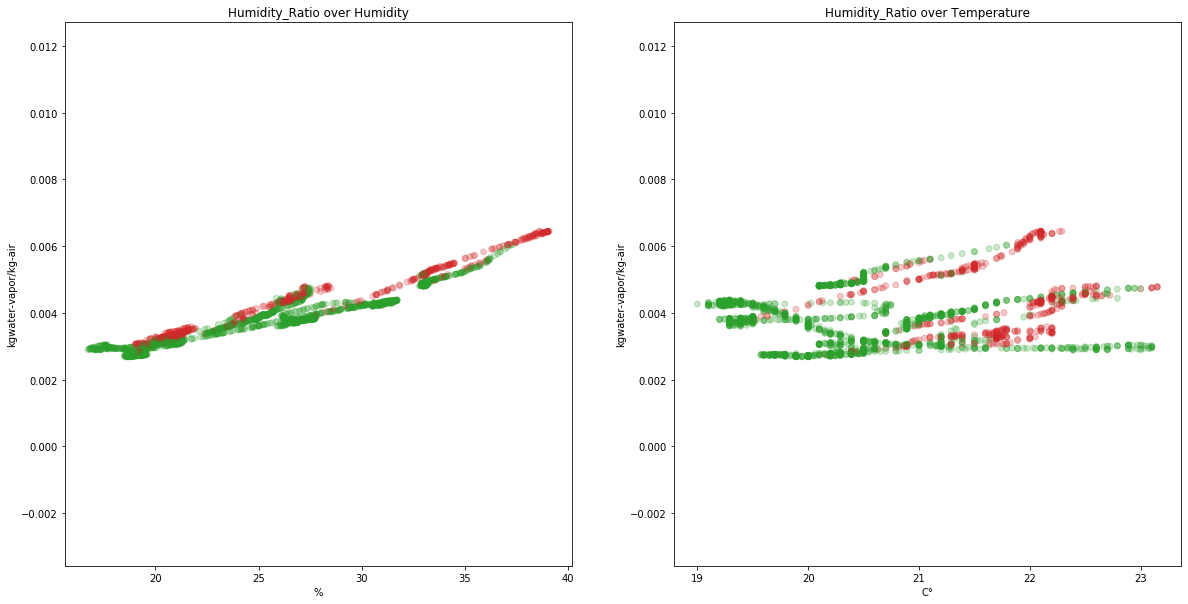

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 10))

sample = data.sample(2500)
axes[0].scatter(sample["Humidity"], sample["Humidity_Ratio"], c=sample["Occupancy"].map(class_colors_map), alpha=0.25)
axes[1].scatter(sample["Temperature"], sample["Humidity_Ratio"], c=sample["Occupancy"].map(class_colors_map), alpha=0.25)

axes[0].set_title("Humidity_Ratio over Humidity")
axes[1].set_title("Humidity_Ratio over Temperature")
axes[0].set_xlabel("%")
axes[0].set_ylabel("kgwater-vapor/kg-air")
axes[1].set_xlabel("C°")
axes[1].set_ylabel("kgwater-vapor/kg-air")


Di seguito viene riprodotta una semplificazione della tabella che lega temperatura e pressione con la massa dell'acqua per Kg di aria come questa riportata in questo sito https://www.engineeringtoolbox.com/water-vapor-air-d_854.html. Si conferma anche qui ciò che è stato ipotizzato precedentemente

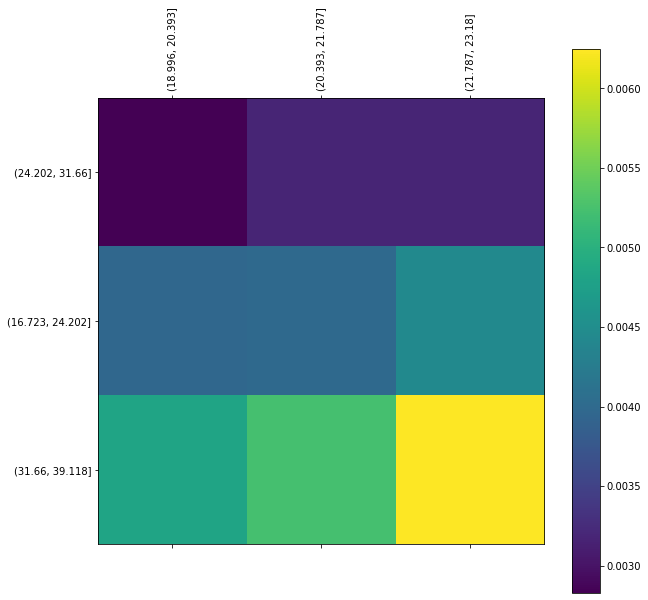

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
#cax = ax.matshow(data, interpolation='nearest')
temperature_interval = pd.cut(data["Temperature"], bins=3)
humidity_interval = pd.cut(data["Humidity"], bins=3)

matrix = ax.matshow(data.groupby([temperature_interval, humidity_interval]).mean().unstack("Temperature")["Humidity_Ratio"])
fig.colorbar(matrix)

#print(data.groupby([temperature_interval, humidity_interval]).max().unstack("Temperature")["Humidity_Ratio"])

ax.set_xticklabels(np.append(temperature_interval.unique().astype("str"), "")[::-1], rotation=90)
ax.set_yticklabels(np.insert(humidity_interval.unique().astype("str"), 0, ""))

#ax.set_title("Humidity ratio in funzione di Temperature e Humidity")


plt.show()

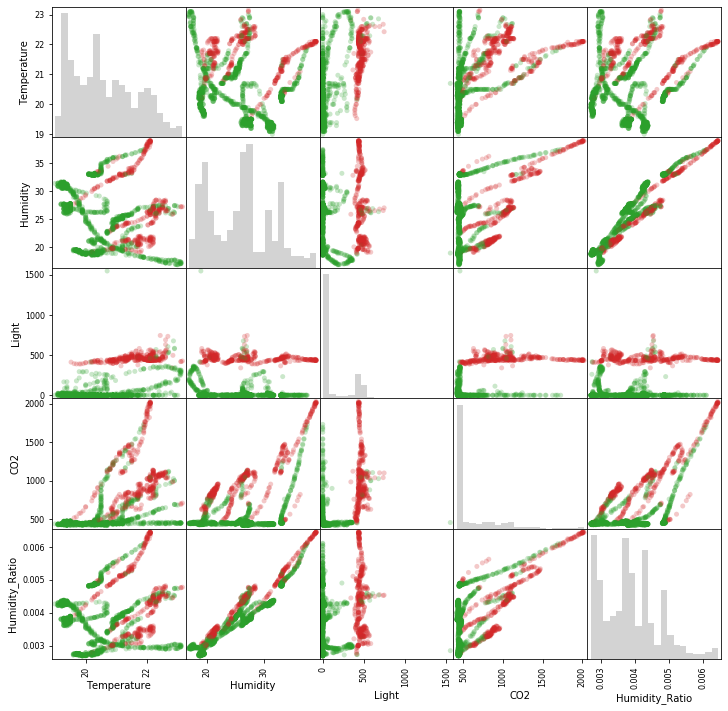

In [18]:
sample = data.sample(2000)
_ = pd.plotting.scatter_matrix(sample.drop(["Occupancy"], axis=1), 
                               c=sample["Occupancy"].map(class_colors_map), 
                               alpha=0.25, 
                               figsize=(12,12), 
                               marker="o",
                               s=25,
                               hist_kwds={"bins": 20, "color": "lightgray"})

Text(0, 0.5, 'C°')

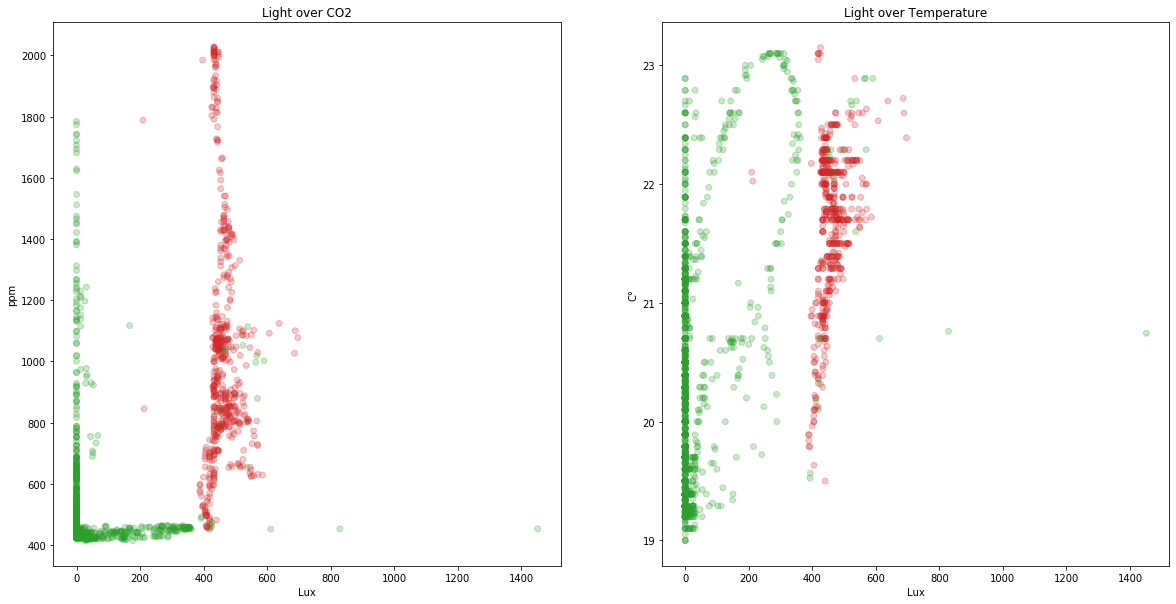

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 10))

sample = data.sample(2500)
axes[0].scatter(sample["Light"], sample["CO2"], c=sample["Occupancy"].map(class_colors_map), alpha=0.25)
axes[1].scatter(sample["Light"], sample["Temperature"], c=sample["Occupancy"].map(class_colors_map), alpha=0.25)

axes[0].set_title("Light over CO2")
axes[1].set_title("Light over Temperature")
axes[0].set_xlabel("Lux")
axes[0].set_ylabel("ppm")
axes[1].set_xlabel("Lux")
axes[1].set_ylabel("C°")


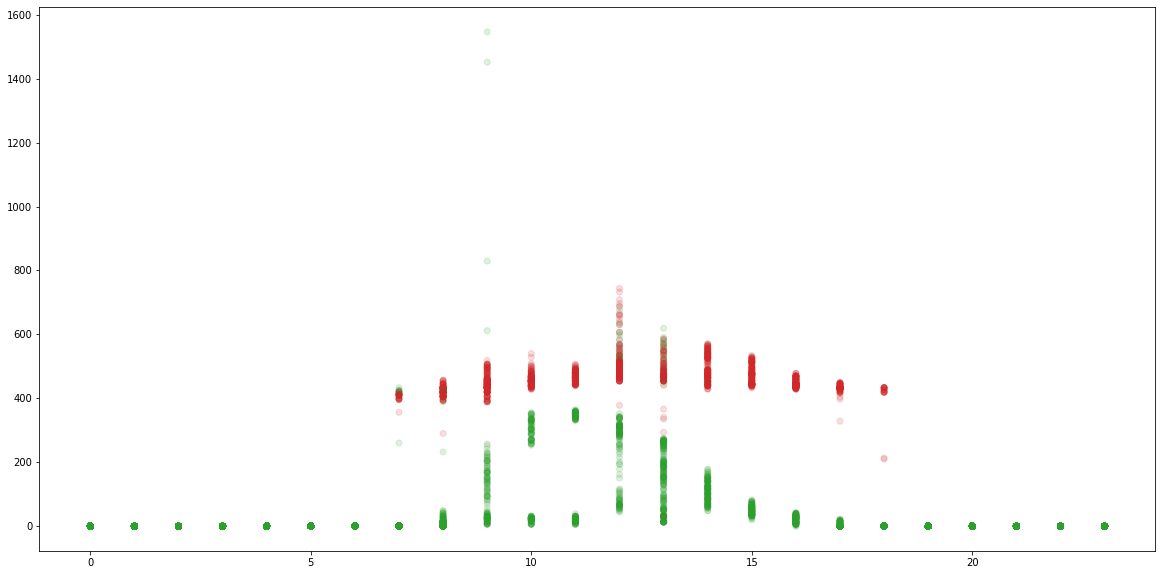

In [20]:
fig = plt.figure(figsize=(20, 10))

plt.scatter(data["Date"].dt.hour, data["Light"], c=data["Occupancy"].map(class_colors_map), alpha=0.15)

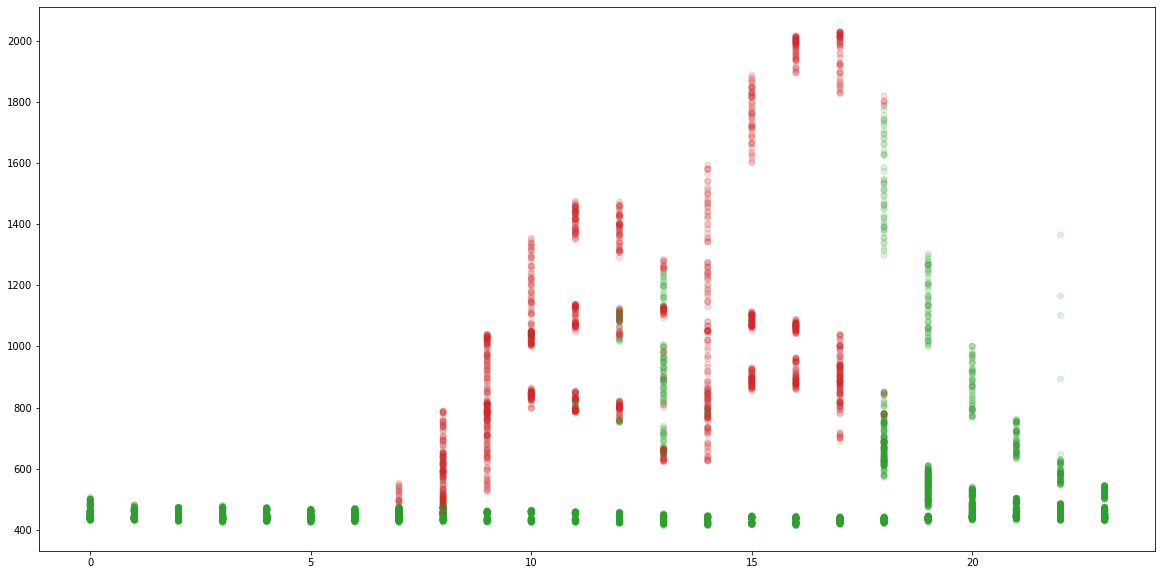

In [21]:
fig = plt.figure(figsize=(20, 10))

plt.scatter(data["Date"].dt.hour, data["CO2"], c=data["Occupancy"].map(class_colors_map), alpha=0.15)

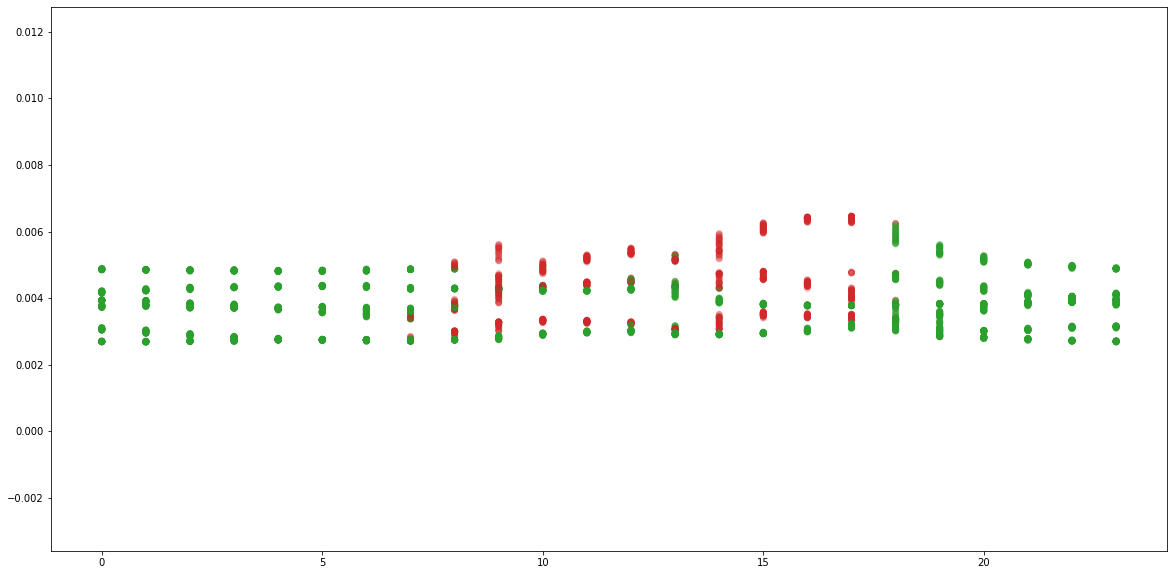

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.scatter(data["Date"].dt.hour, data["Humidity_Ratio"], c=data["Occupancy"].map(class_colors_map), alpha=0.15)

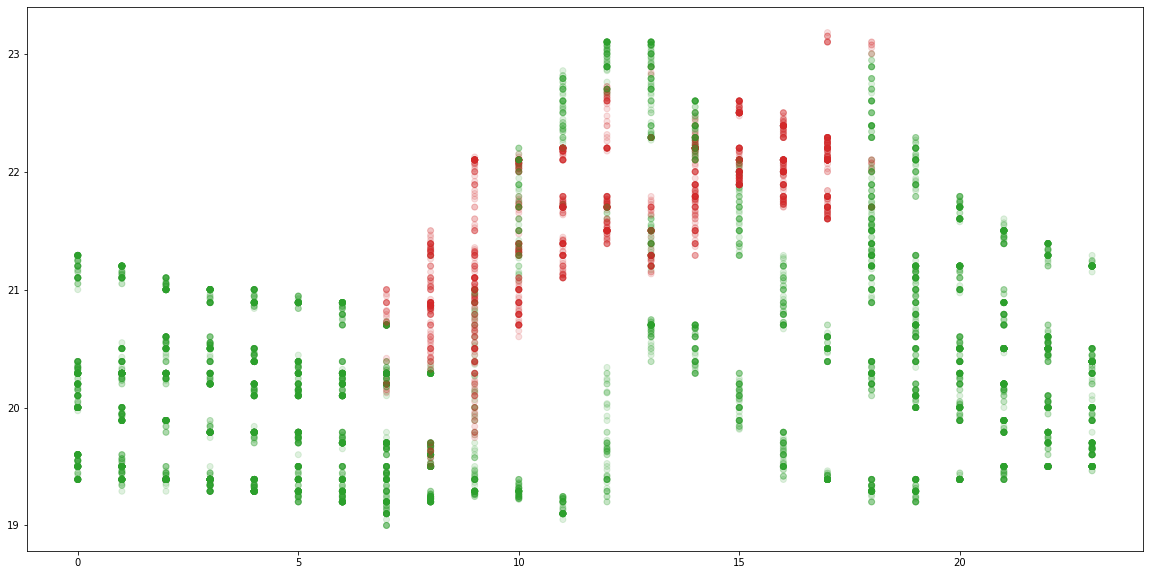

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.scatter(data["Date"].dt.hour, data["Temperature"], c=data["Occupancy"].map(class_colors_map), alpha=0.15)

## Parte 2 - Feature preprocessing

Inizialmente vengono importate le librerie e il validation set dal file zip precedentemente scaricato

In [24]:
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [25]:
def import_dataset_and_preprocess_it(file_name):
    with open(file_validation_set_name) as dataFile:
        data_raw = pd.read_csv(dataFile, sep=",")

    return cast_date_time_and_show(data_raw.rename(columns={"date" : "Date",
                                   "HumidityRatio": "Humidity_Ratio"}))

In [26]:
data_val = import_dataset_and_preprocess_it(file_validation_set_name)

data_val.head()

count                    2665
unique                   2665
top       2015-02-03 07:25:59
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: Date, dtype: object


,Date,Temperature,Humidity,Light,CO2,Humidity_Ratio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


Si può notare che i dati provenienti dal file del validation set rappresentano un sottoinsieme temporale di quelli del training, onde evitare che il modello sfrutti in qualche modo questa caratteristica poco naturale, uniamo i due gruppi, mescoliamo il contenuto ed estraiamo due nuovi set di training e validation, che saranno usati per addestrare modelli con il metodo di **hold-out**

In [27]:
dataset_joined = pd.concat([data_val, data])

print("Shape dei due dataset combinati = {}".format(dataset_joined.shape))

dataset_joined_unix = dataset_joined.copy()
dataset_joined_unix["Date"] = (dataset_joined_unix["Date"] - dt.datetime(1970,1,1)).dt.total_seconds()

Shape dei due dataset combinati = (10808, 7)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    dataset_joined_unix.drop(["Occupancy"], axis=1),
    dataset_joined_unix["Occupancy"],
    test_size=1/3, random_state=42
)

print(X_train["Date"].describe())
print(X_val["Date"].describe())

count    7.205000e+03
mean     1.423231e+09
std      1.952644e+05
min      1.422887e+09
25%      1.423075e+09
50%      1.423238e+09
75%      1.423398e+09
max      1.423561e+09
Name: Date, dtype: float64
count    3.603000e+03
mean     1.423229e+09
std      1.962623e+05
min      1.422887e+09
25%      1.423073e+09
50%      1.423234e+09
75%      1.423400e+09
max      1.423561e+09
Name: Date, dtype: float64


print_eval stampa tre indici di errore:
- Con il metodo score è possibile sapere, utilizzando i dati del validation o del test set, il coefficiente di determinazione del modello appena costruito
- 

In [29]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))
    
def get_coefficients(model, index):
    return pd.Series(model.named_steps["model"].coef_[0], index=index)
    
def fit_and_eval(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    print_eval(X_val, y_val, model)

### Perceptron

Si esegue una prova utilizzando i dati suddivisi precedentemente per allenare un semplice modello di classificazione basato sull'algoritmo Perceptron.

In [30]:
model = Pipeline([
    ("model",  Perceptron())
])
fit_and_eval(model, X_train, y_train, X_val, y_val)

   Mean squared error: 0.25507
       Relative error: inf%
R-squared coefficient: 0.74493


Sono visualizzati i coefficienti del modello per comprendere quali siano le feature più importanti. In questo caso è evidente che le misurazioni della luce e delle tracce di CO2 giochino il ruolo più decisivo nella predizione di nuovi dati. Nonostante i valori non siano molto differenti in ordine di grandezza è possibile provare a **standardizzare** i valori per vedere se il modello può migliorare.

In [31]:
model_coeff = get_coefficients(model, X_train.columns)
model_coeff

Date             -1.072058e+09
Temperature       2.160591e+04
Humidity          3.086290e+04
Light             6.634574e+06
CO2               7.740314e+06
Humidity_Ratio    1.049398e+01
dtype: float64

In [32]:
std_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
fit_and_eval(std_model, X_train, y_train, X_val, y_val)

   Mean squared error: 0.01249
       Relative error: inf%
R-squared coefficient: 0.98751


In [33]:
std_model_coeff = get_coefficients(std_model, X_train.columns)
std_model_coeff

Date             -1.074585
Temperature      -4.866701
Humidity         -4.974188
Light             9.154769
CO2               2.779431
Humidity_Ratio    7.833317
dtype: float64

La standardizzazioen comporta un grande miglioramento dello score. Si può provare ad aggiungere una **penalizzazione di tipo L1** per scoprire se tutte le variabili sono realmente utili al modello, e confermare alcune relazioni fra variabili scoperte durante la fase esplorativa.

In [34]:
std_pen_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1", alpha=0.0001))
])
fit_and_eval(std_pen_model, X_train, y_train, X_val, y_val)

   Mean squared error: 0.01582
       Relative error: inf%
R-squared coefficient: 0.98418


In [35]:
std_pen_model_coeff = get_coefficients(std_pen_model, X_train.columns)
std_pen_model_coeff

Date             -3.001233
Temperature      -1.942962
Humidity          0.000000
Light             7.421260
CO2               1.431194
Humidity_Ratio    2.610306
dtype: float64

Il modello perde un pò di accuratezza, le misure della luce e della CO2 restano importanti, si aggiunge anche la temperatura quasi alla pari della misura di CO2, ma si conferma la poca utilità delle feature legate all'umidità che già in fase esplorativa non avevano raccolto grande interesse. La penalizzazione elimina del tutto la feature `Humidity` a conferma della dipendenza che ha con altre variabili, viene quindi risolto il problema della multicollinearità con la feature `Humidity_Ratio`. Di seguito è mostrata l'evoluzione del valore dei coefficienti

In [36]:
model_coeffs = []
i = 0

for alpha in np.logspace(-3, 0, 4):
    print("alpha {} :\n".format(alpha))
    model = Pipeline([("scaler", StandardScaler()), ("model",  Perceptron(penalty="l1", alpha=alpha))
    ])
    fit_and_eval(model, X_train, y_train, X_val, y_val)
    model_coeffs.append(get_coefficients(model, X_train.columns))
    i += 1
    print("\n")

alpha 0.001 :

   Mean squared error: 0.18762
       Relative error: inf%
R-squared coefficient: 0.81238


alpha 0.01 :

   Mean squared error: 0.012767
       Relative error: inf%
R-squared coefficient: 0.98723


alpha 0.1 :

   Mean squared error: 0.13489
       Relative error: 34.59075%
R-squared coefficient: 0.86511


alpha 1.0 :

   Mean squared error: 0.25507
       Relative error: inf%
R-squared coefficient: 0.74493




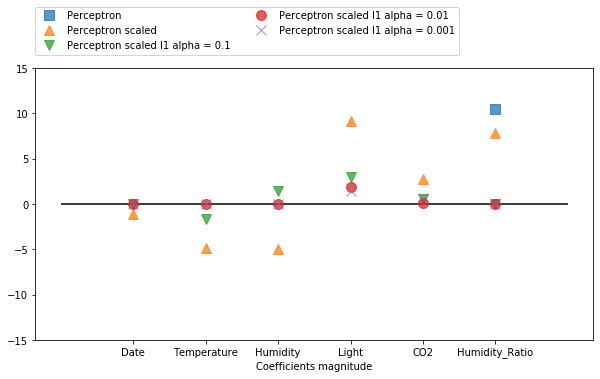

In [37]:
fig = plt.figure(figsize=(10, 5))

plt.plot(model_coeff, 's', alpha=0.75, ms=10, label="Perceptron")
plt.plot(std_model_coeff, '^', alpha=0.75, ms=10, label="Perceptron scaled")
plt.plot(model_coeffs[0], 'v', alpha=0.75, ms=10, label="Perceptron scaled l1 alpha = 0.1")
plt.plot(model_coeffs[1], 'o', alpha=0.75, ms=10, label="Perceptron scaled l1 alpha = 0.01")
plt.plot(model_coeffs[2], 'x', alpha=0.75, ms=10, label="Perceptron scaled l1 alpha = 0.001")
plt.hlines(0, -1, len(model_coeff))
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-15, 15)
plt.xlabel("Coefficients index")
_ = plt.xlabel("Coefficients magnitude")

Inizialmente può essere comodo utilizzare usare tutte le feature per scoprire con mezzi più analitici, come standardizzazione e penalizzazione, le feature meno utili o addirittura dannose per il modello, ma questo non deve offuscare il buon senso e il significato reale delle feature all'interno del modello. La data, precedentemente convertita in formato UNIX, contiene informazioni che nel dataset in possesso risultano ridondanti, come l'anno e il mese che è costante. Il timestamp inoltre ha una natura molto diversa dal resto delle feature, non è una misurazione scientifica assoluta, ma un dato influenzato da aspetti sociali ed esterni dal dataset e dall'ambito di studio. Ad esempio, si potrebbe supporre che se il modello fosse allenato su un dataset molto più ampio, contenente i dati di molti anni, potrebbe essere spinto ad associare ai periodi di festività l'assenza di persone nell'ufficio. Probabilmente non sarebbe completamente scorretto, ne irrimediabile con un allenamento e un giusto bilanciamento delle feature che tenga conto di questa situazione, ma è impoertante osservare queste caratteristiche.

Nel dataset:
- gli anni non cambiano e non dovrebbero influenzare
- i mesi non cambiano e non dovrebbero influenzare
- i giorni sono pochi e non dovrebbero influenzare
- le ore influenzano decisamente le altre misurazioni, è ben visibile il pattern della routine di un ufficio, gli orari di apertura e chiusura sono intuibili nel grafico temporale della feature `Light`
- i minuti sono ripetuti ogni ora, sia in quelle dove è probabile che l'ufficio sia occupato che nelle altre, quindi è più difficile che siano determinanti nella classificazione

Ignorando la data si ha un notevole miglioramento con l'uso puro del Perceptron, ma un abbassamento in quello più complesso.

In [38]:
fit_and_eval(std_model, X_train.drop(["Date"], axis=1), y_train, X_val.drop(["Date"], axis=1), y_val)

   Mean squared error: 0.024424
       Relative error: inf%
R-squared coefficient: 0.97558


In [39]:
fit_and_eval(std_pen_model, X_train.drop(["Date"], axis=1), y_train, X_val.drop(["Date"], axis=1), y_val)

   Mean squared error: 0.012767
       Relative error: inf%
R-squared coefficient: 0.98723


Infine viene considerato solo:
- il giorno, completamente penalizzato insieme ad altre feature, ne rimangono la metà!
- l'ora, completamente penalizzato e ottiene lo score peggiore  
- i minuti, non penalizzati ma abbassano lo score non lievemente
- i secondi, completamente penalizzato ma ottiene lo score migliore

Inoltre la `Humidity` viene penalizzato completamente in tutti i casi, talvolta assieme anche a `Humidity_Ratio`

In [40]:
dataset_joined_daily = dataset_joined.copy()
dataset_joined_hourly = dataset_joined.copy()
dataset_joined_minutely = dataset_joined.copy()
dataset_joined_secondly = dataset_joined.copy()

dataset_joined_daily["Date"] = (dataset_joined_daily["Date"].dt.day).astype("int64")
dataset_joined_hourly["Date"] = (dataset_joined_hourly["Date"].dt.hour).astype("int64")
dataset_joined_minutely["Date"] = (dataset_joined_minutely["Date"].dt.minute).astype("int64")
dataset_joined_secondly["Date"] = (dataset_joined_secondly["Date"].dt.second).astype("int64")

datasets = {"Day" : dataset_joined_daily, 
            "Hour" : dataset_joined_hourly, 
            "Minute" : dataset_joined_minutely, 
            "Second" : dataset_joined_secondly}

for name, value in datasets.items():
    X_train, X_val, y_train, y_val = train_test_split(
        value.drop(["Occupancy"], axis=1),
        value["Occupancy"],
        test_size=1/3, random_state=42
    )
    print(name + ": ")
    fit_and_eval(std_pen_model, X_train, y_train, X_val, y_val)
    print(get_coefficients(std_pen_model, X_train.columns))
    print("\n")

Day: 
   Mean squared error: 0.018873
       Relative error: 6.88956%
R-squared coefficient: 0.98113
Date               0.000000
Temperature       -1.564631
Humidity           0.000000
Light             10.224578
CO2                3.162925
Humidity_Ratio     1.055726
dtype: float64


Hour: 
   Mean squared error: 0.019706
       Relative error: 7.17172%
R-squared coefficient: 0.98029
Date               0.060890
Temperature       -2.335478
Humidity          -0.978834
Light             10.599593
CO2                0.000000
Humidity_Ratio     0.701627
dtype: float64


Minute: 
   Mean squared error: 0.074938
       Relative error: inf%
R-squared coefficient: 0.92506
Date              0.000000
Temperature      -0.752823
Humidity          0.000000
Light             5.364673
CO2               2.861636
Humidity_Ratio    3.040504
dtype: float64


Second: 
   Mean squared error: 0.025812
       Relative error: inf%
R-squared coefficient: 0.97419
Date              0.000000
Temperature      -0.9

In generale non bisogna escludere che il modello generato possa venir usato in altri ambiti, dove non solo gli orari di lavoro potrebbero essere diversi, ma anche l'uso degli impianti di illuminazione, i valori di inquinamento atmosferico e le temperature. 

## Fase 3 - Modellazione 

Importiamo le librerie e l'ultimo file utilizzabile come test set. Anche in questo caso i dati forniti come test set sono un sottoinsime temporale del training come era avvenuto per quello di validation.

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.ensemble import RandomForestClassifier

In [42]:
data_val = import_dataset_and_preprocess_it(file_test_set_name)

data_val.head()

count                    2665
unique                   2665
top       2015-02-03 07:25:59
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: Date, dtype: object


,Date,Temperature,Humidity,Light,CO2,Humidity_Ratio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


Proviamo altri modelli di classificazione, convertendo il timestamp completo ad un timestamp orario. Utilizziamo **Grid Search** e **K-fold cross validation** per stimare calcolare gli iperparametri e stimare l'accuratezza dei modelli creati.

In [70]:
models = {}
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

def print_k_cross_validation_scores(model, X, y, kf):
    scores = cross_val_score(model, X, y, cv=kf)
    print("            Scores: {}\n              Mean: {}\nStandard deviation: {}".format(scores, scores.mean(), scores.std()))

def grid_search_with_cross_validation(model, grid, kf, dataset, scoring=None):
    grid_search = GridSearchCV(model, grid, scoring=scoring, cv=kf, n_jobs=-1)

    X_train, X_val, y_train, y_val = train_test_split(
        dataset.drop(["Occupancy"], axis=1),
        dataset["Occupancy"],
        test_size=1/3, random_state=42
    )

    grid_search.fit(X_train, y_train)
    
    score = grid_search.score(X_val, y_val)

    print("Best cross validation score: {}".format(grid_search.best_score_))
    print("             Test set score: {}".format(score))
    print("                Best params: {}".format(grid_search.best_params_))
    print("             Best estimator: {}".format(grid_search.best_estimator_))
    return grid_search.best_estimator_, score
    #print(pd.DataFrame(grid_search.cv_results_))


### Perceptron

Controlliamo nuovamente il punteggio che otterrebbe ottimizzando gli iperparametri e facendo cross-fold validation. 

In [71]:
per_model = Pipeline([
    ("scaler", StandardScaler()),
    ("per", Perceptron(n_jobs=-1))
])

#print(per_model.get_params())

per_grid = {
    "scaler": [None, StandardScaler()],
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7)
}

per_model, score = grid_search_with_cross_validation(per_model, per_grid, k_fold, dataset_joined_hourly)
models["Perceptron"] = {"Model": per_model, "Score": score}


Best cross validation score: 0.9800138792505205
             Test set score: 0.9875104079933389
                Best params: {'per__alpha': 0.001, 'per__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('per',
                 Perceptron(alpha=0.001, class_weight=None,
                            early_stopping=False, eta0=1.0, fit_intercept=True,
                            max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                            penalty='l1', random_state=0, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False))],
         verbose=False)


### Logistic Regression

In [72]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver='liblinear'))
])

log_grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-4, 2, 7)
}

log_model, score = grid_search_with_cross_validation(log_model, log_grid, k_fold, dataset_joined_hourly)
models["Logistic Regression"] = {"Model" : log_model, "Score": score}

Best cross validation score: 0.9851492019430951
             Test set score: 0.9875104079933389
                Best params: {'lr__C': 0.001, 'lr__penalty': 'l2', 'scaler': None}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler', None),
                ('lr',
                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


### SVM

In [77]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

svm_grid = [
  {'svc__C': np.logspace(-2, 2, 6), 'svc__kernel': ['linear']},
  {'svc__C': np.logspace(-2, 2, 6), 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']},
]

svm_model, score= grid_search_with_cross_validation(svm_model, svm_grid, k_fold, dataset_joined_hourly)
models["Support Vector Machine"] = {"Model": svm_model, "Score": score}

Best cross validation score: 0.9852879944482998
             Test set score: 0.9864002220371912
                Best params: {'svc__C': 15.848931924611142, 'svc__kernel': 'linear'}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=15.848931924611142, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


### K Neighbors Classifier

In [78]:
knc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knc", KNeighborsClassifier(n_jobs=-1))
])

#print(svm_model.get_params())

knc_grid = {"scaler": [None, StandardScaler()],
            'knc__n_neighbors': range(1, 10, 1),
            'knc__weights': ['uniform', 'distance']}

knc_model, score = grid_search_with_cross_validation(knc_model, knc_grid, k_fold, dataset_joined_hourly)
models["K-Neighbor"] = {"Model": knc_model, "Score" : score}

Best cross validation score: 0.9908396946564886
             Test set score: 0.9941715237302248
                Best params: {'knc__n_neighbors': 6, 'knc__weights': 'distance', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knc',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=6, p=2,
                                      weights='distance'))],
         verbose=False)


### Decision Trees

In [79]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

#print(tree_model.get_params())

tree_grid = {"scaler": [None, StandardScaler()],
             'tree__min_samples_split': range(2, 4, 1),
             'tree__min_samples_leaf': range(1, 4, 1), 
             'tree__max_depth': [None] + [i for i in range(2, 7)],
             'tree__max_features': range(2, 7, 1)}

tree_model, score = grid_search_with_cross_validation(tree_model, tree_grid, k_fold, dataset_joined_hourly)
models["Decision Tree"] = {"Model": tree_model, "Score" : score}

Best cross validation score: 0.990145732130465
             Test set score: 0.9897307799056342
                Best params: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'tree__max_depth': None, 'tree__max_features': 4, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=4,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                          

### Random Forest

In [81]:
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1))
])

#print(forest_model.get_params())

forest_grid = {"scaler": [None, StandardScaler()],
             'forest__n_estimators': range(5, 10),
             'forest__min_samples_split': range(2, 5), 
             'forest__max_depth': [None] + [i for i in range(1, 3)],
             'forest__max_features': [int(math.sqrt(6)), int(math.sqrt(6)) - 1, int(math.sqrt(6)) + 1]}

forest_model, score = grid_search_with_cross_validation(forest_model, forest_grid, k_fold, dataset_joined_hourly)
models["Random Forest"] = {"Model": forest_model, "Score" : score}

Best cross validation score: 0.9913948646773074
             Test set score: 0.9938939772411879
                Best params: {'forest__max_depth': None, 'forest__max_features': 1, 'forest__min_samples_split': 3, 'forest__n_estimators': 7, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
             Best estimator: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=1, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
   

## Parte 4 - Valutazione dei modelli di classificazione

Spesso l'accuratezza non è una buona stima della capacità predittiva di un modello di classificazione, in particolare nei casi in cui il dataset è sbilanciato, perchè contiene maggiori record appartenenti ad una classe. In questo caso se si costruisse un modello che predica sempre la stanza coma "non occupata", esso avrebbe una accuratezza di circa il 75% nel predirla non occupata. 

In [82]:
X_train, X_val, y_train, y_val = train_test_split(
    dataset_joined_hourly.drop(["Occupancy"], axis=1),
    dataset_joined_hourly["Occupancy"],
    test_size=1/3, random_state=42)

y_val.value_counts(normalize=True)

0    0.744935
1    0.255065
Name: Occupancy, dtype: float64

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy import stats

Si costruisce una **matrice di confusione** per ciascun modello creato in precedenza, calcolando la **precisione**, la **recall** e la **F1 score**

In [84]:
def calculate_precision_recall_f1(name, X, y) :
    model = models[name]
    y_pred = model["Model"].predict(X)
    
    model["Precision"] = precision_score(y, y_pred, pos_label=1)
    model["Recall"] = recall_score(y, y_pred)
    model["F1_Score"] = f1_score(y, y_pred, average="macro")
    
    print("{}:\n\n \
    Confusion matrix:\n{}\n\n \
           Precision: {}\n \
              Recall: {}\n \
    F1 Score (macro): {}\n\n\n".format(name, 
                                 pd.DataFrame(confusion_matrix(y, y_pred), index=classes, columns=classes), 
                                 model["Precision"], 
                                 model["Recall"], 
                                 model["F1_Score"]))

In [85]:
classes = ["Free", "Occupied"]

for name, model in models.items():
    calculate_precision_recall_f1(name, X_val, y_val)

Perceptron:

     Confusion matrix:
          Free  Occupied
Free      2640        44
Occupied     1       918

            Precision: 0.9542619542619543
               Recall: 0.998911860718172
     F1 Score (macro): 0.9838129253992858



Logistic Regression:

     Confusion matrix:
          Free  Occupied
Free      2640        44
Occupied     1       918

            Precision: 0.9542619542619543
               Recall: 0.998911860718172
     F1 Score (macro): 0.9838129253992858



Support Vector Machine:

     Confusion matrix:
          Free  Occupied
Free      2636        48
Occupied     1       918

            Precision: 0.9503105590062112
               Recall: 0.998911860718172
     F1 Score (macro): 0.982398254850283



K-Neighbor:

     Confusion matrix:
          Free  Occupied
Free      2674        10
Occupied    11       908

            Precision: 0.9891067538126361
               Recall: 0.9880304678998912
     F1 Score (macro): 0.9923284875076208



Decision Tree:

   

Si verifica con **confidenza** al 95% se l'accuratezza dei modelli è statisticamente significativa

In [86]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Confidence: {} {}".format(d_minus, d_plus))

per_error = 1 - models["Perceptron"]["F1_Score"]
knc_error = 1 - models["K-Neighbor"]["F1_Score"]
tree_error = 1 - models["Decision Tree"]["F1_Score"]
forest_error = 1 - models["Random Forest"]["F1_Score"]

difference_between_two_models(per_error, knc_error, 0.95)

difference_between_two_models(tree_error, knc_error, 0.95)

difference_between_two_models(tree_error, forest_error, 0.95)

difference_between_two_models(forest_error, knc_error, 0.95)

Confidence: 0.004311421207642287 0.012719703009027791
Confidence: 0.001905454577070015 0.00984277823350534
Confidence: 0.0015344032489659955 0.009534717129443685
Confidence: -0.003078613862263049 0.003757726294428723


## Parte 5 - Analisi del modello migliore

In [87]:
from sklearn.dummy import DummyClassifier

In [88]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

random_score = random.score(X_val, y_val)
models["Dummy"] = {"Model" : random, "Score": random_score}
random_score

0.4948653899528171

In [89]:
calculate_precision_recall_f1("Dummy", X_val, y_val)

difference_between_two_models(1 - models["Decision Tree"]["F1_Score"], 1 - models["Dummy"]["F1_Score"], 0.99)

difference_between_two_models(1 - models["Random Forest"]["F1_Score"], 1 - models["Dummy"]["F1_Score"], 0.99)

difference_between_two_models(1 - models["K-Neighbor"]["F1_Score"], 1 - models["Dummy"]["F1_Score"], 0.99)


Dummy:

     Confusion matrix:
          Free  Occupied
Free      1337      1347
Occupied   473       446

            Precision: 0.2487451199107641
               Recall: 0.485310119695321
     F1 Score (macro): 0.46196206544812946



Confidence: 0.5046577293083473 0.5443268820000601
Confidence: 0.5103984062736738 0.5496553254131432
Confidence: 0.5107507550432632 0.5499820890757195
